In [1]:
import numpy as np
import copy
import matplotlib.pyplot as plt

# Dataset

In [2]:
raw_data = open("dinos.txt", "r").read().lower()
raw_data[:1000]

'aachenosaurus\naardonyx\nabdallahsaurus\nabelisaurus\nabrictosaurus\nabrosaurus\nabydosaurus\nacanthopholis\nachelousaurus\nacheroraptor\nachillesaurus\nachillobator\nacristavus\nacrocanthosaurus\nacrotholus\nactiosaurus\nadamantisaurus\nadasaurus\nadelolophus\nadeopapposaurus\naegyptosaurus\naeolosaurus\naepisaurus\naepyornithomimus\naerosteon\naetonyxafromimus\nafrovenator\nagathaumas\naggiosaurus\nagilisaurus\nagnosphitys\nagrosaurus\nagujaceratops\nagustinia\nahshislepelta\nairakoraptor\najancingenia\najkaceratops\nalamosaurus\nalaskacephale\nalbalophosaurus\nalbertaceratops\nalbertadromeus\nalbertavenator\nalbertonykus\nalbertosaurus\nalbinykus\nalbisaurus\nalcovasaurus\nalectrosaurus\naletopelta\nalgoasaurus\nalioramus\naliwalia\nallosaurus\nalmas\nalnashetri\nalocodon\naltirhinus\naltispinax\nalvarezsaurus\nalwalkeria\nalxasaurus\namargasaurus\namargastegos\namargatitanis\namazonsaurus\nammosaurus\nampelosaurus\namphicoelias\namphicoelicaudia\namphisaurus\namtocephale\namtosaur

In [3]:
list_data = raw_data.split("\n")
print(list_data[:100])
print()
print(len(list_data))

['aachenosaurus', 'aardonyx', 'abdallahsaurus', 'abelisaurus', 'abrictosaurus', 'abrosaurus', 'abydosaurus', 'acanthopholis', 'achelousaurus', 'acheroraptor', 'achillesaurus', 'achillobator', 'acristavus', 'acrocanthosaurus', 'acrotholus', 'actiosaurus', 'adamantisaurus', 'adasaurus', 'adelolophus', 'adeopapposaurus', 'aegyptosaurus', 'aeolosaurus', 'aepisaurus', 'aepyornithomimus', 'aerosteon', 'aetonyxafromimus', 'afrovenator', 'agathaumas', 'aggiosaurus', 'agilisaurus', 'agnosphitys', 'agrosaurus', 'agujaceratops', 'agustinia', 'ahshislepelta', 'airakoraptor', 'ajancingenia', 'ajkaceratops', 'alamosaurus', 'alaskacephale', 'albalophosaurus', 'albertaceratops', 'albertadromeus', 'albertavenator', 'albertonykus', 'albertosaurus', 'albinykus', 'albisaurus', 'alcovasaurus', 'alectrosaurus', 'aletopelta', 'algoasaurus', 'alioramus', 'aliwalia', 'allosaurus', 'almas', 'alnashetri', 'alocodon', 'altirhinus', 'altispinax', 'alvarezsaurus', 'alwalkeria', 'alxasaurus', 'amargasaurus', 'amarga

In [4]:
chars = sorted(list(set(raw_data)))
vocab_size = len(chars)
print(chars)
print()
print(vocab_size)

['\n', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']

27


* The characters are a-z (26 characters) plus the "\n" (or newline character).
* In this assignment, the newline character "\n" plays a role similar to the `<EOS>` (or "End of sentence") token discussed in lecture.  
    - Here, "\n" indicates the end of the dinosaur name rather than the end of a sentence. 

In [5]:
char_to_idx = {ch:i for i,ch in enumerate(chars)}
idx_to_char = {i:ch for i,ch in enumerate(chars)}

print(idx_to_char)
print()
print(char_to_idx)

{0: '\n', 1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z'}

{'\n': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26}


* `char_to_idx`: In the cell below, you'll create a Python dictionary (i.e., a hash table) to map each character to an index from 0-26.
* `idx_to_char`: Then, you'll create a second Python dictionary that maps each index back to the corresponding character. 
    -  This will help you figure out which index corresponds to which character in the probability distribution output of the softmax layer. 

# Helper Funcs

In [6]:
def softmax(x):
    """
    x -- shape of (vocab_size, batch_size)
    """
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

In [7]:
def clip_gradients(gradients, max_value):
    # use deep copy here if we want to compare gradients before and after clipping
    gradients = copy.deepcopy(gradients)
    
    dWaa, dWax, dWya, dba, dby = gradients['dWaa'], gradients['dWax'], gradients['dWya'], gradients['dba'], gradients['dby']
    for grad in [dWaa, dWax, dWya, dba, dby]:
        np.clip(grad, -max_value, max_value, out=grad)  # out = in_place
    
    gradients = {"dWaa": dWaa, "dWax": dWax, "dWya": dWya, "dba": dba, "dby": dby}
    return gradients

# Training

In [8]:
def initialize_parameters(n_x, n_a, n_y):
    # np.random.seed(1)
    
    Wax = np.random.randn(n_a, n_x) * 0.01 
    Waa = np.random.randn(n_a, n_a) * 0.01
    Wya = np.random.randn(n_y, n_a) * 0.01
    ba = np.zeros((n_a, 1))
    by = np.zeros((n_y, 1))
    
    parameters = {"Wax": Wax, "Waa": Waa, "Wya": Wya, "ba": ba,"by": by}
    return parameters

In [9]:
def rnn_cell_forward(x, a_prev, parameters):
    Waa, Wax, Wya, by, ba = parameters['Waa'], parameters['Wax'], parameters['Wya'], parameters['by'], parameters['ba']
    
    a_next = np.tanh(np.dot(Waa, a_prev) + np.dot(Wax, x) + ba)
    yt_pred = softmax(np.dot(Wya, a_next) + by)
    
    return a_next, yt_pred

In [10]:
def rnn_forward(X, Y, a0, parameters, vocab_size=27):
    """
    Performs forward propagation for a simple character-level RNN.

    Arguments:
    ----------
    X : list of int representing input character indices for each time step, shape of (Tx, ). Example: [0, 3, 5, 2, ...]
    Y : list of int representing target (expected) character indices for each time step, shape of (Tx, )
    a0 : initial hidden state, shape of (n_a, 1)
    parameters : dictionary containing the model parameters:
            Waa -- Hidden-to-hidden weight matrix, shape of (n_a, n_a)
            Wax -- Input-to-hidden weight matrix, shape of (n_a, n_x)
            Wya -- Hidden-to-output weight matrix, shape of (n_y, n_a)
            ba  -- Bias for hidden state, shape of (n_a, 1)
            by  -- Bias for output layer, shape of (n_y, 1)
    vocab_size : int, optional (default = 27)
        Size of the vocabulary (number of unique characters).

    Returns:
    --------
    loss : Total cross-entropy loss for the entire sequence.
    cache : Tuple storing values needed for the backward pass: (y_pred, a, x), where:
                y_pred -- dict of predicted probabilities at each time step, each y_pred[t] has shape (n_y, 1)
                a      -- dict of hidden states, each a[t] has shape (n_a, 1)
                x      -- dict of input vectors, each x[t] has shape (n_x, 1)
    """
    
    # Store cache
    y_pred, a, x = {}, {}, {}

    # Store a0 in cache
    a[-1] = np.copy(a0)

    # Loss acumulated
    loss = 0
    
    for t in range(len(X)):
        # Create one-hot vector for the token at timestep t
        x[t] = np.zeros((vocab_size, 1))  # (n_x, 1)
        if X[t] is not None:  # need if because we will put None at the first index, the first timestep needs input as zero-vector
            x[t][X[t]] = 1  # make x[t] one-hot vector, one at position X[t]

        # Forward
        a[t], y_pred[t] = rnn_cell_forward(x[t], a[t-1], parameters)

        # Compute loss
        prob_for_correct_token = np.clip(y_pred[t][Y[t], 0], 1e-8, 1.0)  # y_pred[t] returns shape of (n_y, 1)
        loss -= np.log(prob_for_correct_token)

    cache = (y_pred, a, x)
    return loss, cache

In [11]:
def rnn_cell_backward(dz_t, da_next, cache_t):
    (a_next, a_prev, xt, parameters) = cache_t
    Wax = parameters["Wax"]
    Waa = parameters["Waa"]
    Wya = parameters["Wya"]
    ba = parameters["ba"]
    by = parameters["by"]

    # Gradients from logits
    dWya = np.dot(dz_t, a_next.T)  # (n_y, 1) @ (n_a, 1).T
    dby = np.sum(dz_t, axis=1, keepdims=True)  # (n_y, 1)
    da_next_from_z = np.dot(Wya.T, dz_t)  # (n_y, n_a).T @ (n_y, 1)

    # Total gradient of a_next from logits and the next timestep
    da_total = da_next + da_next_from_z  # (n_a, 1)

    # Gradient of a_raw through TANH function
    dtanh = da_total * (1 - a_next**2)  # (n_a, 1)

    # Gradient from a_raw
    dWax = np.dot(dtanh, xt.T)  # (n_a, 1) @ (n_x, 1).T
    dWaa = np.dot(dtanh, a_prev.T)  # (n_a, 1) @ (n_a, 1).T
    dba = np.sum(dtanh, axis=1, keepdims=True)  # (n_a, 1)
    dxt = np.dot(Wax.T, dtanh)  # (n_a, n_x).T  @ (n_a, 1)
    da_prev = np.dot(Waa.T, dtanh)  # (n_a, n_a).T @ (n_a, 1)

    # Dict of gradients
    gradients_t = {
        "dxt": dxt, 
        "da_prev": da_prev, 
        "dWax": dWax, 
        "dWaa": dWaa,
        "dWya": dWya, 
        "dba": dba, 
        "dby": dby
    }
    return gradients_t

In [12]:
def rnn_backward(Y, parameters, cache):
    """
    Backward pass through time for a simple RNN using cached values.

    Arguments
    ----------
    Y : list of int
        Sequence of target (expected) character indices, shape (Tx, ).
    parameters : dict
        Dictionary containing RNN parameters (Waa, Wax, Wya, ba, by)
    cache : tuple
        Tuple containing (y_pred, a, x) from forward pass

    Returns
    -------
    gradients : dict
        Gradients for all parameters
    """

    (y_pred, a, x) = cache
    Waa, Wax, Wya, ba, by = parameters['Waa'], parameters['Wax'], parameters['Wya'], parameters['ba'], parameters['by']
    
    gradients = {
        "dWax": np.zeros_like(Wax),
        "dWaa": np.zeros_like(Waa),
        "dWya": np.zeros_like(Wya),
        "dba": np.zeros_like(ba),
        "dby": np.zeros_like(by)
    }
    
    da_next = np.zeros_like((a[-1]))
    
    # Backprop
    for t in reversed(range(len(Y))):
        # Compute gradient of Loss with respect to Logits: dz_t = y_pred[t] - one-hot vector at Y[t] position
        dz_t = np.copy(y_pred[t])
        dz_t[Y[t]] -= 1

        # Backprop
        cache_t = (a[t], a[t-1], x[t], parameters)
        gradients_t = rnn_cell_backward(dz_t, da_next, cache_t)

        # Accumulate gradients over timesteps
        gradients['dWya'] += gradients_t['dWya']
        gradients['dWaa'] += gradients_t['dWaa']
        gradients['dWax'] += gradients_t['dWax']
        gradients['dba'] += gradients_t['dba']
        gradients['dby'] += gradients_t['dby']

        # Reset da_next for the backprop
        da_next = gradients_t["da_prev"]

    return gradients

In [13]:
def update_parameters(parameters, gradients, learning_rate):
    parameters['Wax'] += -learning_rate * gradients['dWax']
    parameters['Waa'] += -learning_rate * gradients['dWaa']
    parameters['Wya'] += -learning_rate * gradients['dWya']
    parameters['ba']  += -learning_rate * gradients['dba']
    parameters['by']  += -learning_rate * gradients['dby']
    # return is optional because we update the original dict
    return parameters

In [14]:
def optimize(X, Y, a_prev, parameters, learning_rate=0.01):
    """
    Execute one step of the optimization to train the model.
    
    Arguments:
    X -- list of integers, where each integer is a number that maps to a character in the vocabulary.
    Y -- list of integers, exactly the same as X but shifted one index to the left.
    a_prev -- previous hidden state.
    parameters -- python dictionary containing:
                        Wax -- Weight matrix multiplying the input, numpy array of shape (n_a, n_x)
                        Waa -- Weight matrix multiplying the hidden state, numpy array of shape (n_a, n_a)
                        Wya -- Weight matrix relating the hidden-state to the output, numpy array of shape (n_y, n_a)
                        b --  Bias, numpy array of shape (n_a, 1)
                        by -- Bias relating the hidden-state to the output, numpy array of shape (n_y, 1)
    learning_rate -- learning rate for the model.
    
    Returns:
    loss -- value of the loss function (cross-entropy)
    a[len(X)-1] -- the last hidden state, of shape (n_a, 1)
    """

    loss, cache = rnn_forward(X, Y, a_prev, parameters)
    gradients = rnn_backward(Y, parameters, cache)

    gradients_clipped = clip_gradients(gradients, 5)
    update_parameters(parameters, gradients_clipped, learning_rate)

    # cache = (y_pred, a, x)
    a_last = cache[1][len(X)-1]  # pick the last hidden state to be the a0 for the next batch (stateful RNN)
    
    return loss, a_last

# Inference

Now, assume that your model is trained, and you would like to generate new text (characters). The process of generation is explained in the picture below:

<img src="images/inference_through_sampling.png" style="width:600;height:400px;">
<caption><center><font color='purple'>In this picture, you can assume the model is already trained. You pass in $x^{\langle 1\rangle} = \vec{0}$ at the first time-step, and have the network sample one character at a time. </center></caption>

In [15]:
def generate_text_from_sampling(parameters, char_to_idx, seed):
    """
    Sample a sequence of characters according to a sequence of probability distributions output of the RNN

    Arguments:
    parameters -- Python dictionary containing the parameters Waa, Wax, Wya, ba, and by. 
    char_to_idx -- Python dictionary mapping each character to an index.
    seed -- Used for grading purposes. Do not worry about it.

    Returns:
    indices -- A list of length n containing the index of the sampled characters.
    """

    Waa, Wax, Wya, by, ba = parameters['Waa'], parameters['Wax'], parameters['Wya'], parameters['by'], parameters['ba']
    vocab_size = by.shape[0]  # by(n_y, 1)
    n_a = ba.shape[0]  # ba(n_a, 1)

    x = np.zeros((vocab_size, 1))
    a_prev = np.zeros((n_a, 1))

    indices = []
    counter = 0
    newline_idx = char_to_idx['\n']
    idx = -1

    # Forward until newline_char or the output length <= 50
    while (idx != newline_idx and counter != 50):
        # Forward
        a = np.tanh(np.dot(Waa, a_prev) + np.dot(Wax, x) + ba)
        z = np.dot(Wya, a) + by
        y = softmax(z)  # (vocab_size, 1)

        # Sample a character for the next input from the probability distribution y
        np.random.seed(seed + counter)
        idx = np.random.choice(list(range(vocab_size)), p=y.ravel())  
        indices.append(idx)

        # Update new hidden state & input for the next forward
        x = np.zeros((vocab_size, 1))
        x[idx] = 1  # one-hot vector
        a_prev = a
        
        # Pseudo-random
        seed += 1
        counter += 1

    if (counter == 50):
        indices.append(char_to_idx['\n'])
        
    return indices 

# Model

In [16]:
def run_model(list_data, list_vocab, epochs=20, learning_rate=0.001):
    char_to_idx = {ch:i for i,ch in enumerate(list_vocab)}
    idx_to_char = {i:ch for i,ch in enumerate(list_vocab)}
    
    total_samples = len(list_data)
    vocab_size = len(list_vocab)
    hidden_size = int(vocab_size*2.5)
    
    # Init the original dict to store params and update here
    parameters = initialize_parameters(vocab_size, hidden_size, vocab_size)

    # Loss
    losses = []
    epoch_losses = []

    seed = 0  # for inference
    
    for i in range(epochs+1):
        a_prev = np.zeros((hidden_size, 1))
        epoch_loss = 0
    
        for j in range(total_samples):
            text = list_data[j]
            char_indices = [char_to_idx[char] for char in text]
            
            # Prepare input X and label Y
            X = [None] + char_indices
            Y = X[1:] + [char_to_idx["\n"]]

            # Train in stochastic mode
            loss, a_last = optimize(X, Y, a_prev, parameters, learning_rate)
            
            epoch_loss += loss
            a_prev = a_last  # we use the a_last of the previous sample to be the a0 of the next sample
            
            if j % 300 == 0:
                losses.append(loss)
                            
        epoch_losses.append(epoch_loss/total_samples)
        print(f"LOSS AT EPOCH {i}: {epoch_losses[-1]}")

        if i % 5 == 0:
            n_texts_predicted = 5
            for k in range(n_texts_predicted):
                indices_predicted = generate_text_from_sampling(parameters, char_to_idx, seed)
                text_predicted = ''.join(idx_to_char[i] for i in indices_predicted)
                text_predicted = text_predicted[0].upper() + text_predicted[1:]
                text_predicted = text_predicted.replace("\n", ".")
                print(f"Text {k} generated from sampling: {text_predicted}")
                seed += 1

        print("~"*100)

    return epoch_losses, losses

In [17]:
# np.random.seed(0)
texts = copy.deepcopy(list_data)
np.random.shuffle(texts)
print(texts[:100])

['nedcolbertia', 'kitadanisaurus', 'barsboldia', 'quetecsaurus', 'eocarcharia', 'medusaceratops', 'coelosaurus', 'saraikimasoom', 'agrosaurus', 'cryptosaurus', 'apatosaurus', 'koreanosaurus', 'eocursor', 'xingxiulong', 'amtocephale', 'batyrosaurus', 'mirischia', 'rapator', 'camposaurus', 'velociraptor', 'texacephale', 'byronosaurus', 'tochisaurus', 'megalosaurus', 'europasaurus', 'dracorex', 'sinocoelurus', 'kinnareemimus', 'ningyuansaurus', 'bactrosaurus', 'nopcsaspondylus', 'coronosaurus', 'dolichosuchus', 'gavinosaurus', 'spiclypeus', 'europelta', 'lambeosaurus', 'gracilisuchus', 'latirhinus', 'beipiaosaurus', 'shuangmiaosaurus', 'machairoceratops', 'craspedodon', 'rachitrema', 'traukutitan', 'lycorhinus', 'dinodocus', 'amargasaurus', 'seitaad', 'bashunosaurus', 'probactrosaurus', 'hypselospinus', 'pakisaurus', 'qinlingosaurus', 'bravoceratops', 'archaeornithoides', 'nuthetes', 'peishansaurus', 'diracodon', 'gobititan', 'laiyangosaurus', 'gansutitan', 'proa', 'proiguanodon', 'prodei

In [18]:
epoch_losses, losses = run_model(texts, chars, epochs=50, learning_rate=0.002)

LOSS AT EPOCH 0: 38.04606048324926
Text 0 generated from sampling: Omwuusaocrpcuhsrt.
Text 1 generated from sampling: Lod.
Text 2 generated from sampling: Lxuusaocrpcuhsrt.
Text 3 generated from sampling: Oda.
Text 4 generated from sampling: Xuusaocrpcuhsrt.
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
LOSS AT EPOCH 1: 32.80668546819645
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
LOSS AT EPOCH 2: 29.26012410854656
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
LOSS AT EPOCH 3: 28.17900811425505
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
LOSS AT EPOCH 4: 27.32619751759717
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
LOSS AT EPOCH 5: 26.530800148758214
Text 0 generated from sampling: A.
Text 1 generated from sam

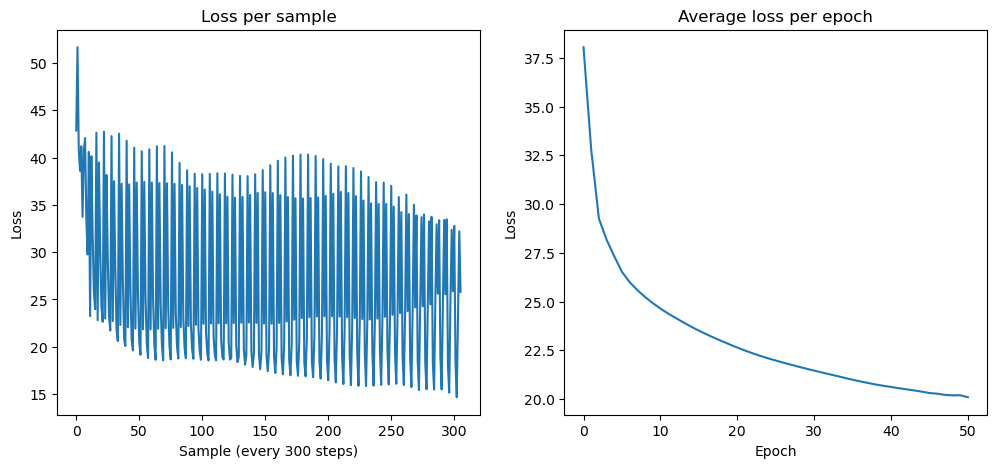

In [19]:
plt.figure(figsize=(12, 5))

# Loss every 100 samples
plt.subplot(1, 2, 1)
plt.plot(losses)
plt.title("Loss per sample")
plt.xlabel("Sample (every 300 steps)")
plt.ylabel("Loss")

# Average loss per epoch
plt.subplot(1, 2, 2)
plt.plot(epoch_losses)
plt.title("Average loss per epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

In [20]:
from difflib import SequenceMatcher

def find_similar_names(generated_name, target_names=texts, top_k=3):
    similarities = []
    for t in texts:
        sim = SequenceMatcher(None, generated_name.lower(), t.lower()).ratio()
        sim_rounded = float(f"{sim:.4f}")
        similarities.append((t, sim_rounded))
        
    similarities.sort(key=lambda x: x[1], reverse=True)
    return similarities[:top_k]

In [24]:
find_similar_names("Lonysaurus")

[('longosaurus', 0.8571), ('loncosaurus', 0.8571), ('laosaurus', 0.8421)]

In [25]:
find_similar_names("Rocausaurus")

[('rocasaurus', 0.9524), ('arcusaurus', 0.8571), ('riojasaurus', 0.8182)]

In [26]:
find_similar_names("Siumechalus")

[('stereocephalus', 0.64), ('suchosaurus', 0.6364), ('spinosuchus', 0.6364)]